In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob

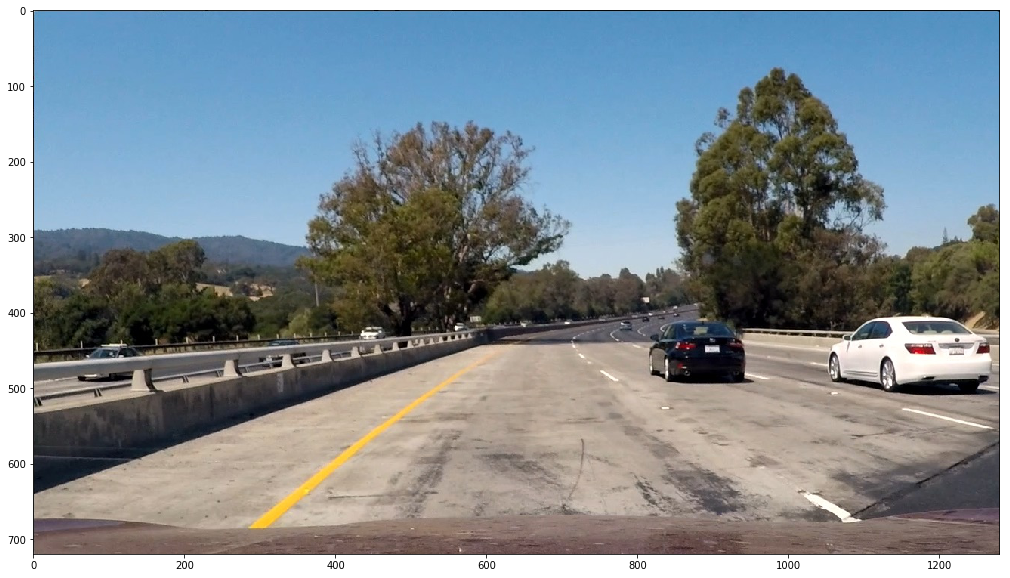

In [96]:
path = "test_images/"
fnames = os.listdir(path)
idx = 1
fname = os.path.join(path, fnames[idx])
img = cv2.imread(fname)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.figure(figsize=(20,10))
plt.imshow(img)

#### Possibilities for color thresholding

- apply sobel filter in (x and/or y direction), and/or (magnitude and/or direction)
- apply a color threshold on grayscale image and/or image in RGB space
- convert to HLS space and threshold any of the H/L/S dimensions


It's possible to combine any of the above. The objective is to get a binary image (pixel values only 0 or 1)

In [97]:
# abs x/y thresholding
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient=="x":
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient=="y":
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    else:
        raise ValueError("orient has to be x or y!!!")
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    # binary_output = np.copy(img) # Remove this line
    
    return binary_output

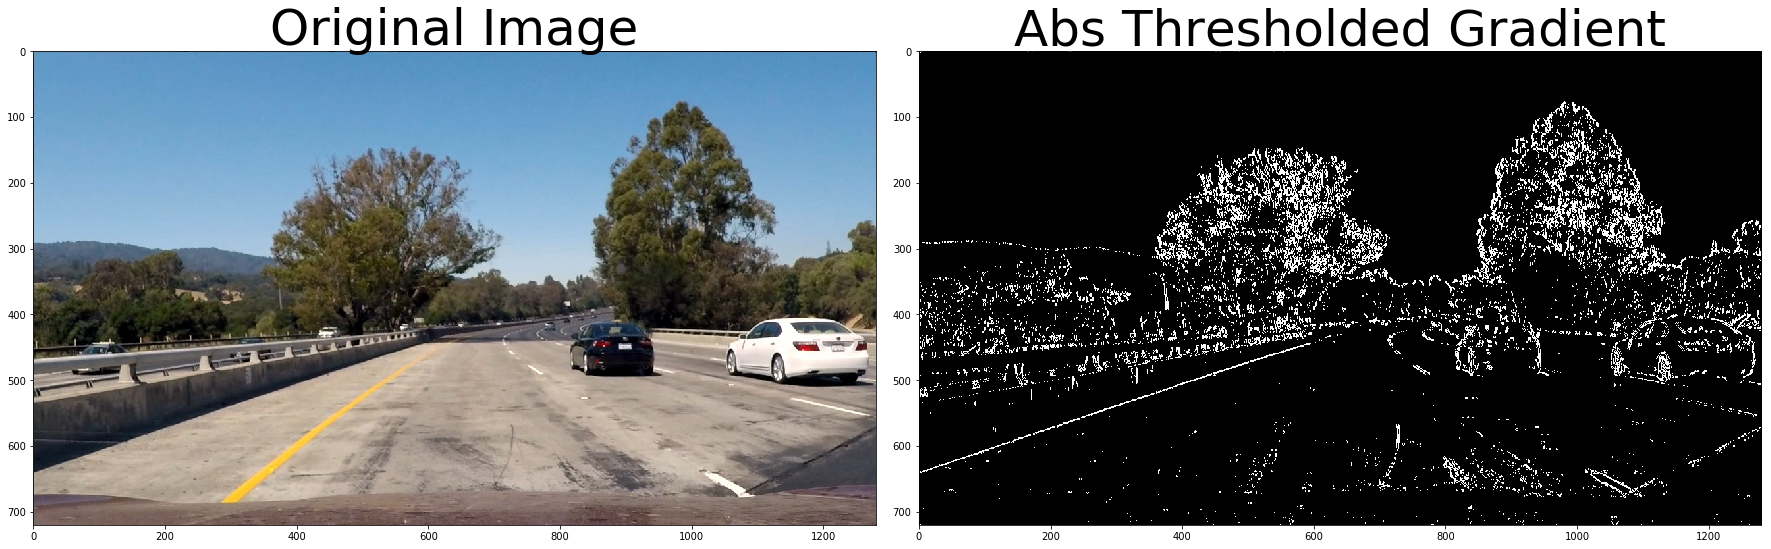

In [98]:
grad_binary = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Abs Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [99]:
# magnitude thresholding
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return binary_output

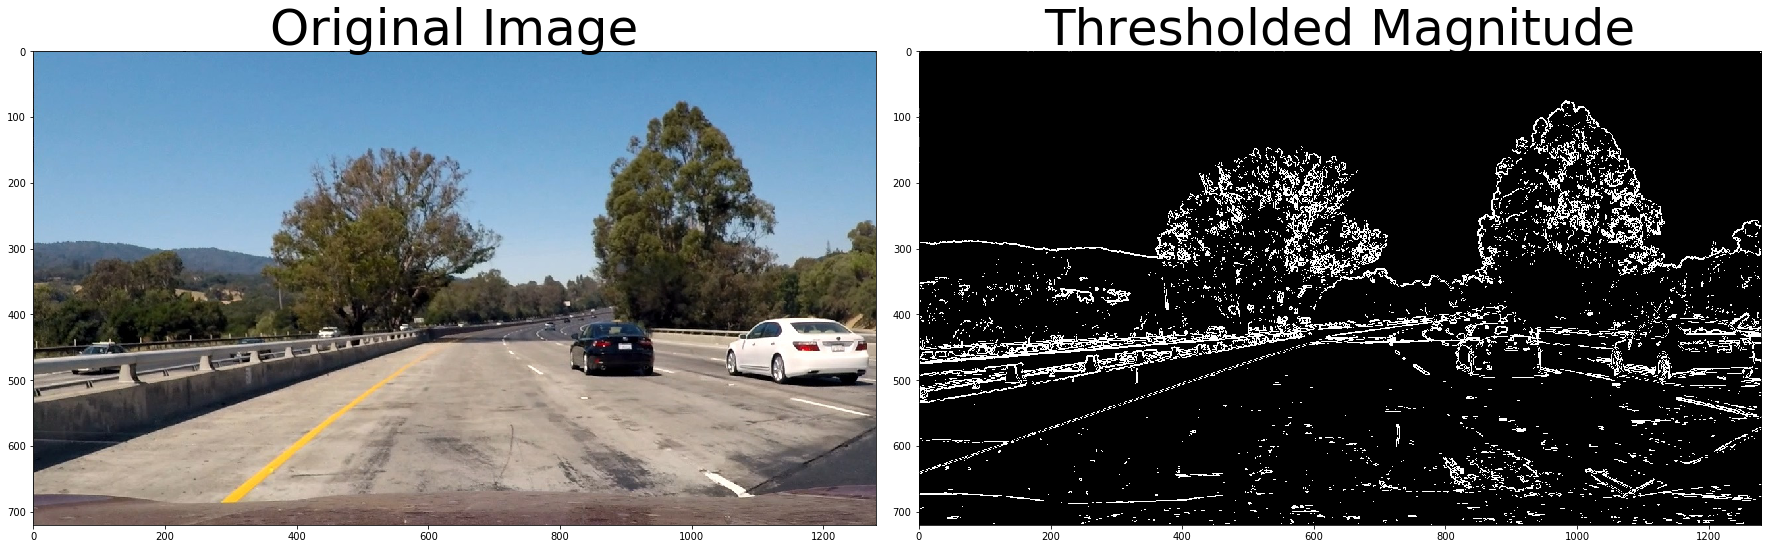

In [100]:
mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [101]:
# Direction thresholding
def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(gray)
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    # binary_output = np.copy(img) # Remove this line
    return binary_output

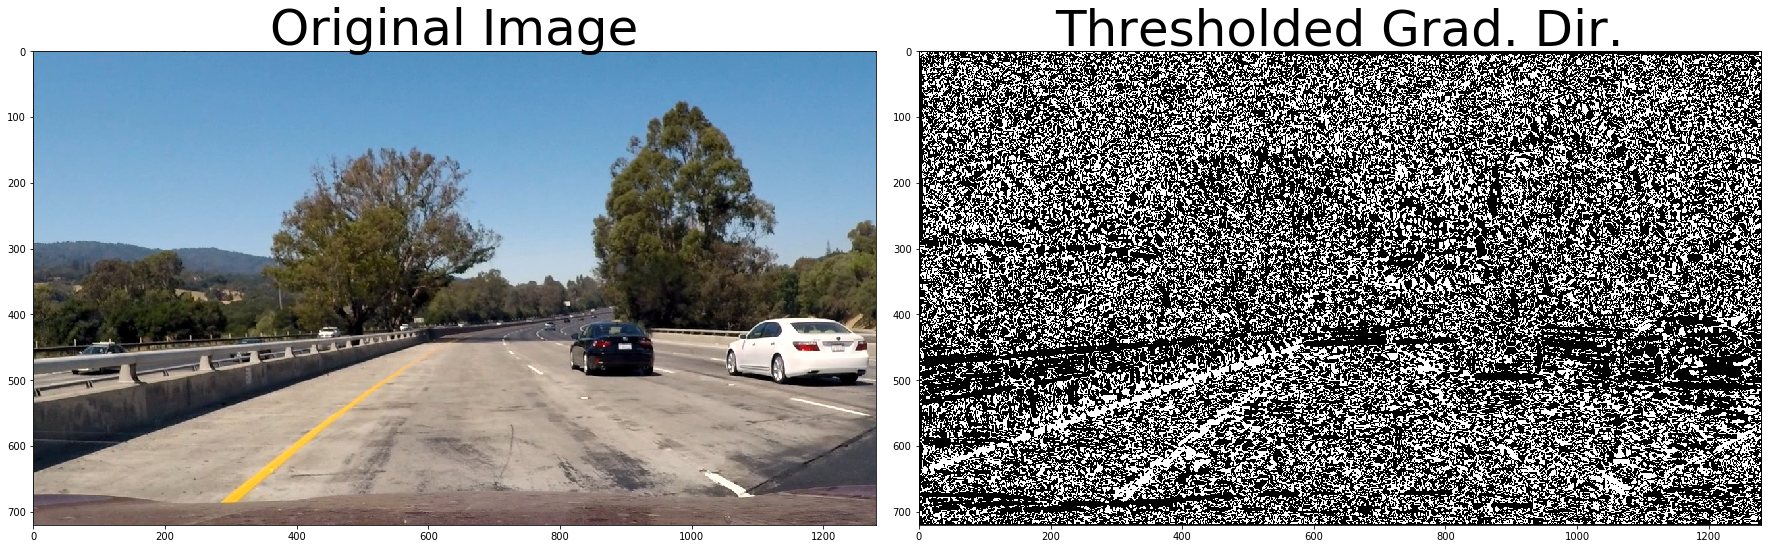

In [102]:
# Run the function
dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

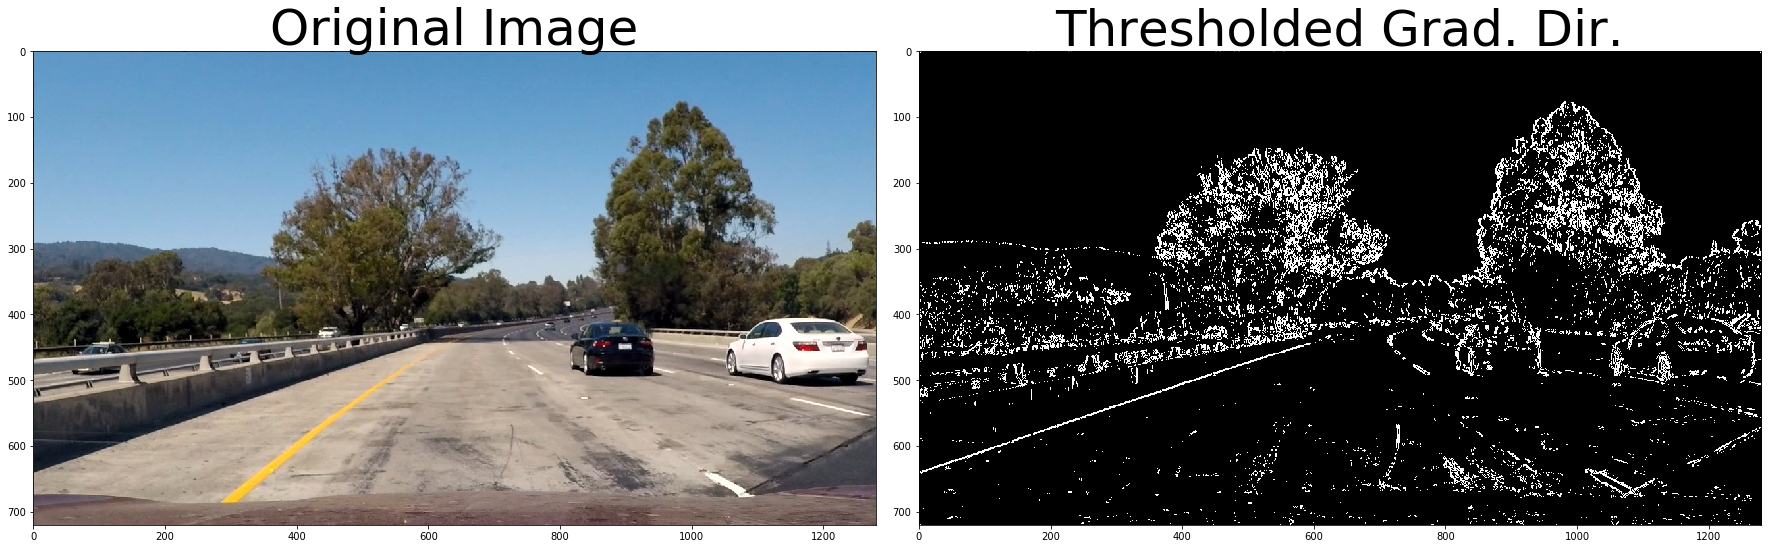

In [103]:
# Combined sobel threshold image
combined = np.zeros_like(dir_binary)
combined[((grad_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [24]:
# ToDo: implement function for thresholding RGB channels and gray image

In [104]:
hls_dict = dict(H=0, L=1, S=2)

In [105]:
def hls_select(img, hls_channel="S", thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    channel_num = hls_dict[hls_channel]
    channel_dim = hls[:,:,channel_num]
    # 3) Return a binary image of threshold result
    binary_output = np.zeros_like(channel_dim)
    binary_output[(channel_dim > thresh[0]) & (channel_dim <= thresh[1])] = 1
    # binary_output = np.copy(img) # placeholder line
    return binary_output

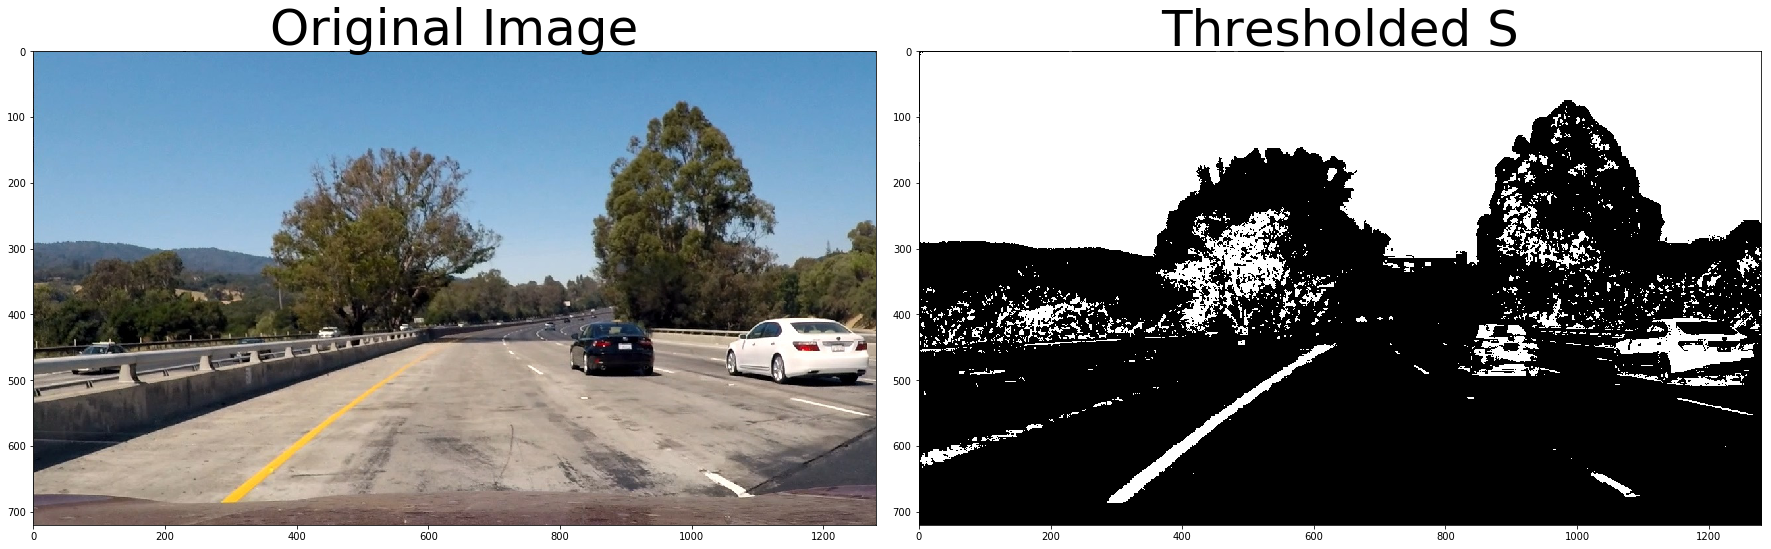

In [106]:
hls_channel="S"
hls_binary = hls_select(img, hls_channel=hls_channel, thresh=(90, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title(f'Thresholded {hls_channel}', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

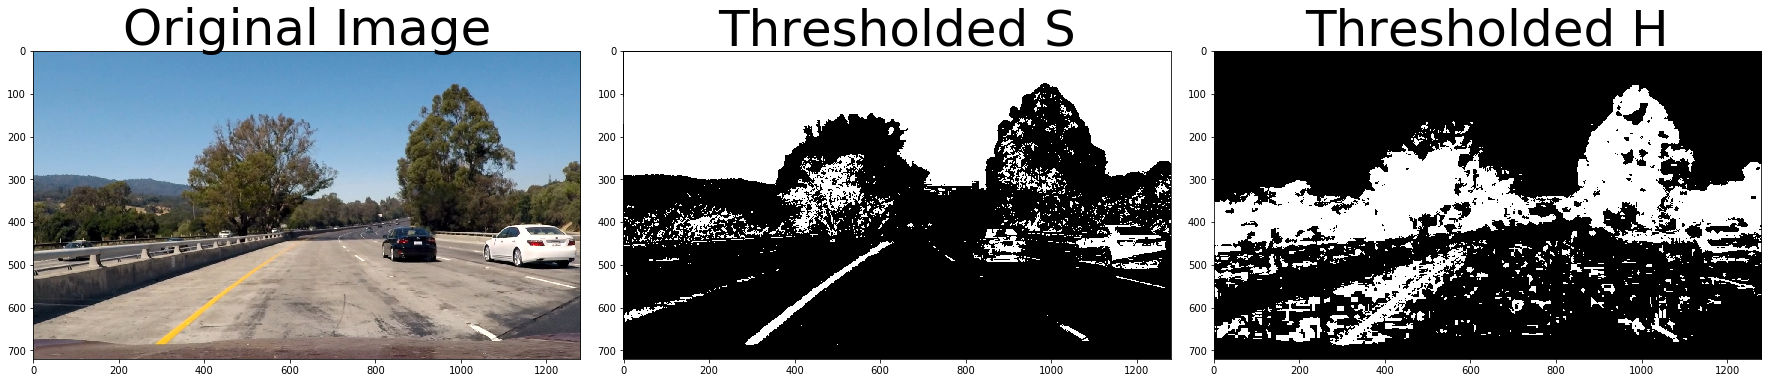

In [107]:
from functools import partial
s_binary = hls_select(img, hls_channel="S", thresh=(90,255))
h_binary = hls_select(img, hls_channel="H", thresh=(15, 100))

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(s_binary, cmap='gray')
ax2.set_title(f'Thresholded S', fontsize=50)
ax3.imshow(h_binary, cmap='gray')
ax3.set_title(f'Thresholded H', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [58]:
# Combined sobel and color thresholding
color_binary = np.dstack(( np.zeros_like(grad_binary), combined, s_binary)) * 255

In [59]:
color_binary.shape

(720, 1280, 3)

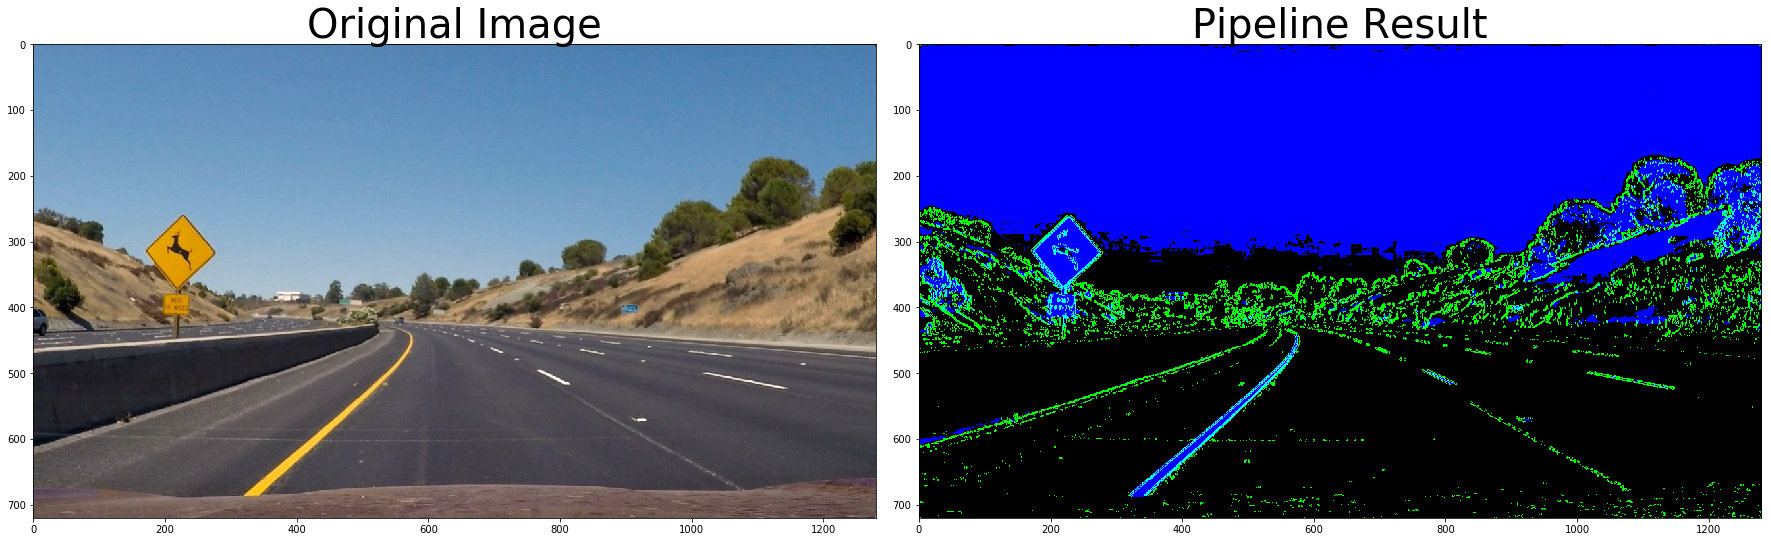

In [60]:
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(color_binary)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [56]:
combined.shape

(720, 1280)

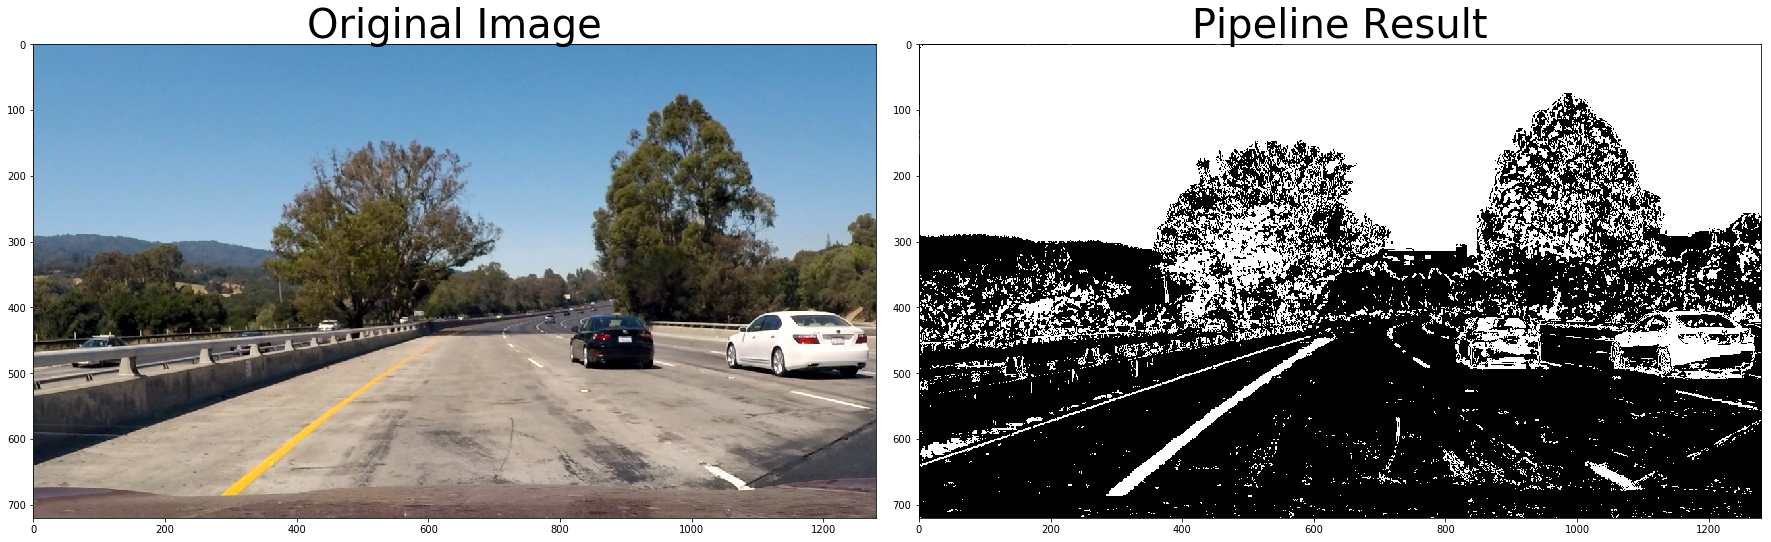

In [108]:
combined_binary = np.zeros_like(combined)
combined_binary[(s_binary == 1) | (combined == 1)] = 1
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(combined_binary, cmap="gray")
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [67]:
# ToDo: implement function which allows for dynamic combination of any type of color/gradient thresholding

Next step: Take the threshold-pipeline result and perform perspective transform on it

In [109]:
dist_pickle = pickle.load(open("camera_cal/dist_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
img_size = (img.shape[1], img.shape[0])

In [110]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, mtx, dist, src, dst):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    return warped, M

In [115]:
src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

In [112]:
src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])

In [116]:
top_down, perspective_M = corners_unwarp(img, mtx, dist, src, dst)

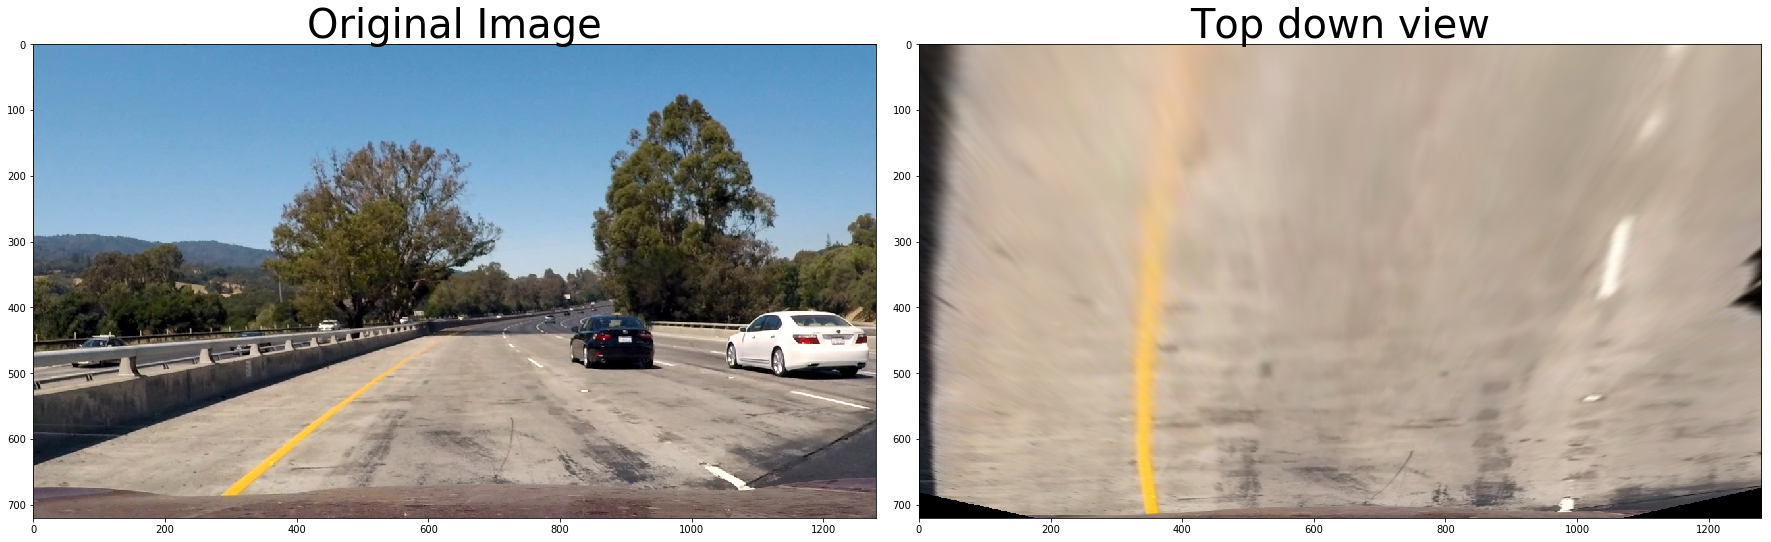

In [117]:
combined_binary = np.zeros_like(combined)
combined_binary[(s_binary == 1) | (combined == 1)] = 1
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(top_down)
ax2.set_title('Top down view', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)